# Team Alpha

## AI for Emotional Wellbeing: Mental Heath Chatbot

* Mental health is a critical aspect of overall well-being, yet access to mental health support remains limited for many. Artificial intelligence and natural language processing have the potential to provide accessible and scalable mental health support.


### Team 
* Uma Maheshwaril
* Raemil Corniel
* Sonal Parmar
* Jharana Adhikari
* Aparna Suresh

### steps 

1. Load libraries
2. Define classes and functions
3. Load data
4. Exploratory Data Analysis
5. Data preprocesing 
6. Train / Test split
7. Train the model 
8. Evaluate the model




#### 1. Load Libraries

In [137]:
#install needed 
pip install missingno
pip install keras
pip install xformers

SyntaxError: invalid syntax (1515554057.py, line 2)

In [247]:
#import libraries 

import warnings
warnings.filterwarnings('ignore')
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

#### 2.Define classes and functions

In [248]:

#load file and return file loaded 
def readJSON(filename):
    with open(filename) as f:
        file = json.load(f)
    return file


#create a empty data frame to load or data.json
def createDF():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

#convert json file int o df, all the data from json file is inserted into the new df
def fromJSONToDF(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

#get corpus, get list of words
def getCorpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

# once the predictions are ready, we have coupled all the metrics together, so it can be futher utilize and added 
# in a df
def computeMetrics(pred):

    #get labels from predciton
    labels = pred.label_ids
    #get each pred
    predictions = pred.predictions.argmax(-1)
    #using sklearn.metrics set of metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

#PyTorch class used to represent a dataset. This custom data loader class is designed to handle tokenized data and corresponding labels, making it easy to feed data into a PyTorch model for training or inference.
class DataLoader(Dataset):
    
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
               
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)


#### Functions to handle preprocesing data

In [249]:
import nltk
import re
import inflect
import string


from nltk.corpus import stopwords
from nltk.corpus import wordnet
from itertools import product
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

#download stop words
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('popular')

#create instance of lemma
lemmatizer = WordNetLemmatizer()

#create instance of spell correction 
spell = Speller(lang='en')

#initialize engine
inflect_engine = inflect.engine()


#list of possible contractions to fix any grammar and provide best answer
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

#create contraction list separate by pipe
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Add all punctuation characters
ignore_words=[]
ignore_words.extend(string.punctuation)
# Remove duplicates by converting to a set and back to a list
ignore_words = list(set(ignore_words))

#tokenize words
def tokenizeWrods(sentence):
     # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)

    return sentence_words

#correct spelling 
def correctSpelling(words_list):

    #correct each word, iterate and use the autocorrect to return appropiate word
    corrected_list = [spell(word) for word in words_list]

    return corrected_list


#correct contractions to original form ex I'm -> I am
def expandContractions(sentence, contractions_dict=contractions_dict):
    def replace(match):
        #find  if any contraction exist 
        return contractions_dict[match.group(0)]
    #remove replace contraction for original form
    return contractions_re.sub(replace, sentence)

#remove stop words 
def removeStopWords(words_list):
    #get the English stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords iterate if word is not in the stopword then I added to list
    corrected_list = [word for word in words_list if word not in stop_words]
    corrected_list = [word for word in words_list if word not in ignore_words]

    return corrected_list

#get word tags noun,verb,adverb, adjetive 
def getWordnetPos(word):
    
    #identify the tag that correspond
    tag = nltk.pos_tag([word])[0][1][0].upper()
   
    #create a tag dict
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    #return type of word noun,verb,adverb, adjetive 
    return tag_dict.get(tag, wordnet.NOUN)

def generateVariations(sentence_words):
    
    all_variations=[]
    for word in sentence_words:
        #lemma word by type 
        lemmatized_word = lemmatizer.lemmatize(word, getWordnetPos(word))
        #add to a variations, example if the sentences is I'm starving 
        #will be added [starve,starving]
        word_variations = set([word, lemmatized_word] )
        
        # Add singular and plural forms if the word is a noun, if is a noun
        #to increase our matching chances ex. people, person etc
#         if get_wordnet_pos(word) == wordnet.NOUN:
#             #add singular and plural of origninal word
#             word_variations.add(inflect_engine.singular_noun(word) or word)
#             word_variations.add(inflect_engine.plural_noun(word) or word)
#             #add s and p of lemma 
#             word_variations.add(inflect_engine.singular_noun(lemmatized_word) or lemmatized_word)
#             word_variations.add(inflect_engine.plural_noun(lemmatized_word) or lemmatized_word)
        
        #for initial stage we will add everything to the senctence
        #like it was part of it ex. [starve, starving]
        for variation in word_variations:
            all_variations.append(variation)

    #return all the sentence_word + variations 
    return all_variations


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raemilcorniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raemilcorniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/raemilcorniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/raemilcorniel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/raemilcorniel/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/raemilcorniel/nltk_data...
[nltk_data]    |   Package ga

#### 3.Load data


In [250]:
#read file with patterns and responses 
filename = 'data.json'

intents = readJSON(filename)

In [251]:
#create a df that will be used for the EDA 
df = createDF()
df

,Pattern,Tag


In [252]:
#fill out the df with the JSON file
df = fromJSONToDF(intents, df)
df.head()

,Pattern,Tag
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [253]:
#make a copy of the data that will be used for the preprocesing, this is in case during the EDA, we change the df
mentalHealthDF = df.copy()
mentalHealthDF.head()

,Pattern,Tag
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


####  4.Exploratory Data Analysis

In [254]:
#dimenssion of the dataset 
df.shape

(514, 2)

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514 entries, 0 to 513
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  514 non-null    object
 1   Tag      514 non-null    object
dtypes: object(2)
memory usage: 12.0+ KB


In [256]:
print(f"Amount of classes or tags = {len(df['Tag'].unique())} ")
    


Amount of classes or tags = 145 


In [257]:
df.isnull().sum()
#show null values 
    


Pattern    0
Tag        0
dtype: int64

In [258]:
df['Tag'].value_counts()

Tag
help_treatment_available                   19
loneliness                                 12
counseling-fundamentals                    12
casual                                     11
greeting                                    8
                                           ..
control_passivity_schizophrenia             1
persistent_hallucinations_schizophrenia     1
persistent_delusions_schizophrenia          1
friends                                     1
ask                                         1
Name: count, Length: 145, dtype: int64

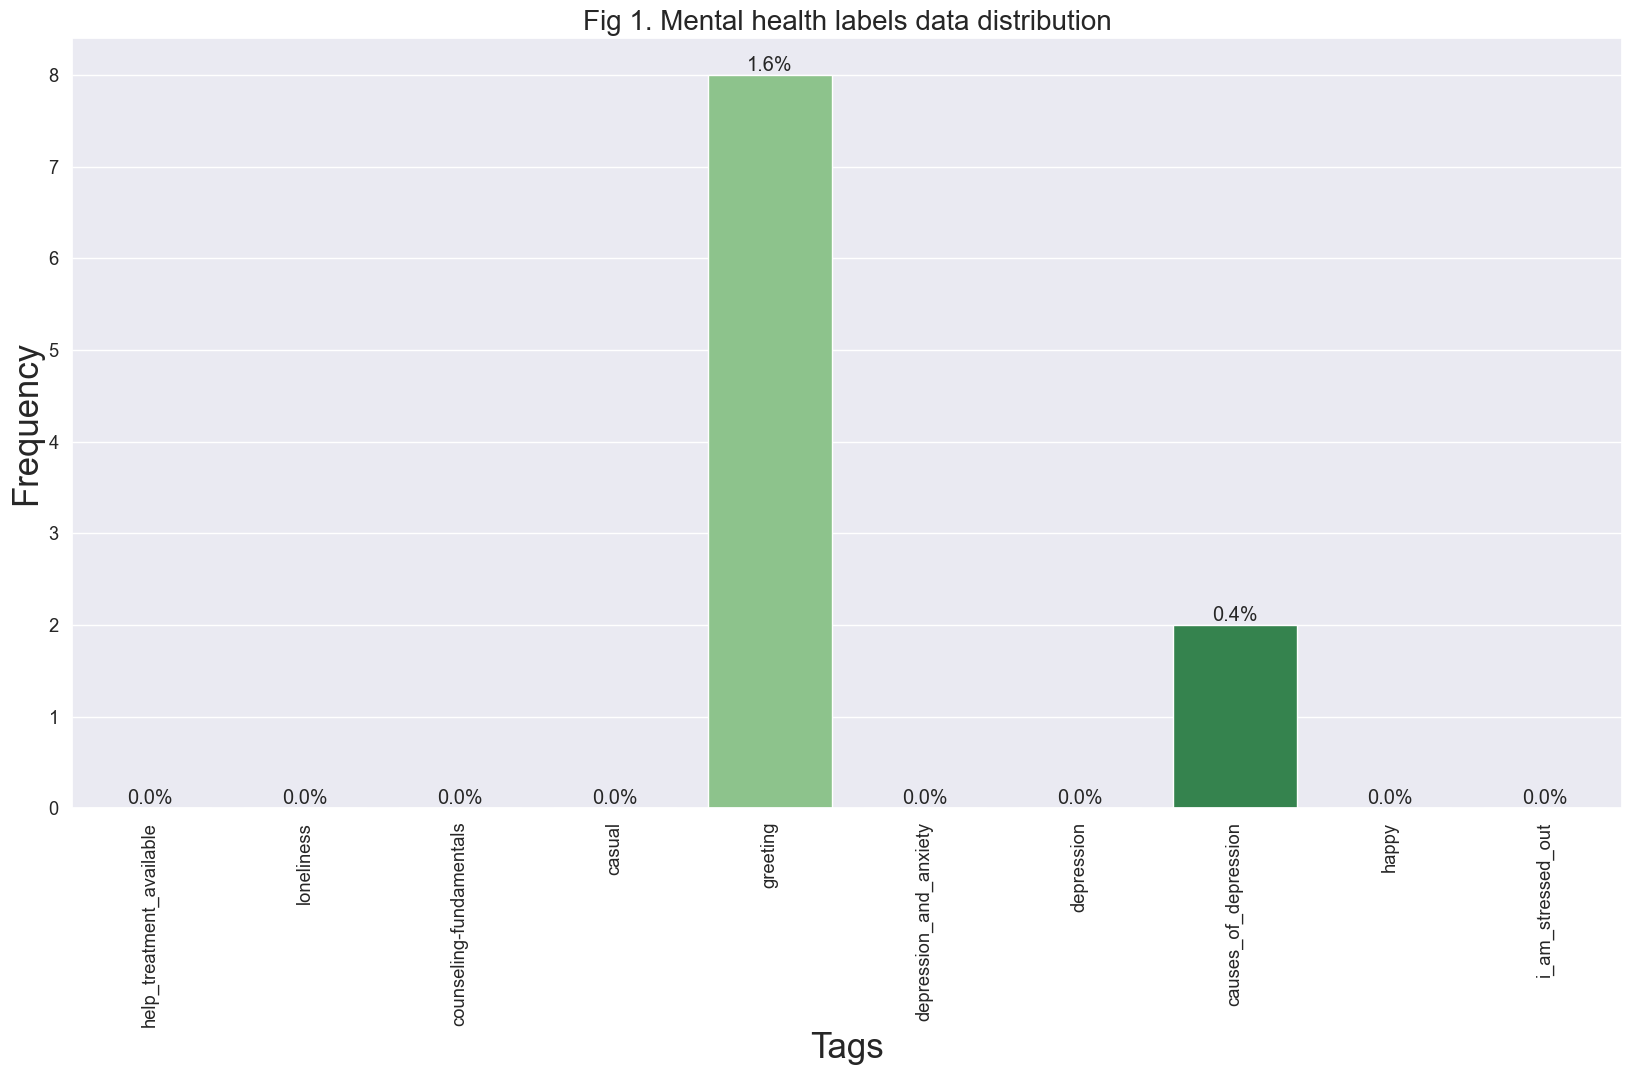

In [259]:
#create a distribution of our tag or labels

#get list of tags - only show top 10 tags
top_tags = df['Tag'].value_counts().index[:10]


# Filter the DataFrame to include rows with top 10 tags
df_top = df[df['Tag'].isin(top_tags)].head(10)


#size of font
sns.set(font_scale = 1.2)

#size of the figure 
plt.figure(figsize=(20,10))
#use sns countplot to show the top 10 tags 
ax = sns.countplot(x='Tag', data=df_top, palette='Greens', order = top_tags, hue=None)
#add title 
plt.title("Fig 1. Mental health labels data distribution", fontsize=20)
#add tick rotation for readability 
plt.xticks(rotation = 'vertical')
#add x and y labels 
plt.xlabel('Tags', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
ax.yaxis.set_label_position('left')

#add percentage to each bar
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

#show graph 
plt.show()




Along with the value counts we can see in this graph our most represented tag which are the folowing: 
help_treatment_available 19
loneliness 12
counseling-fundamentals 12
casual 11
greeting 8

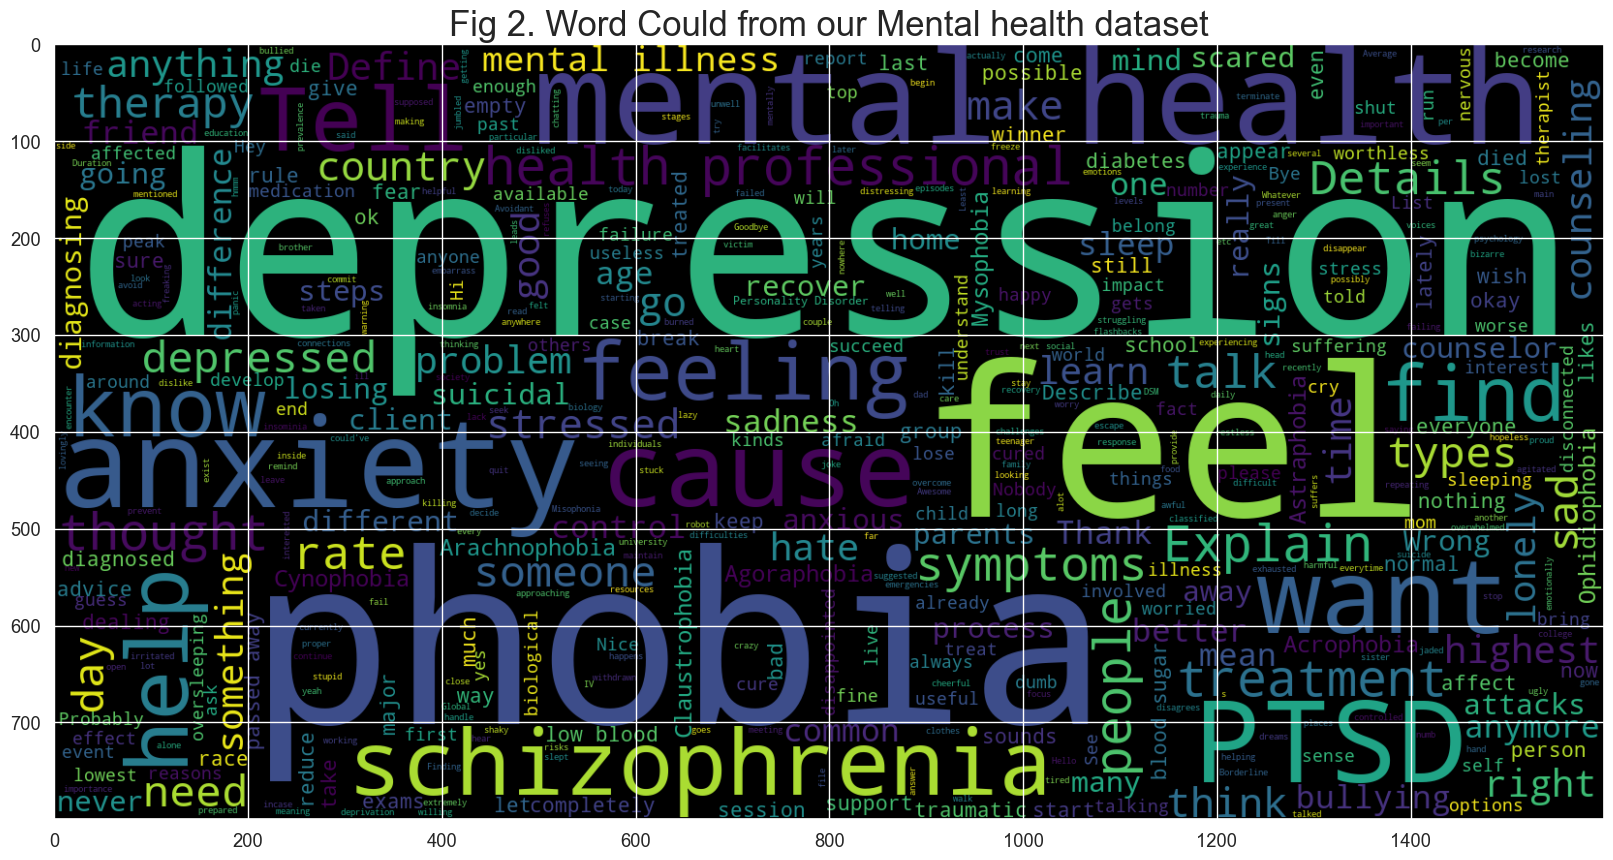

In [260]:
#word cloud with our most repeated words

#define figure size 
plt.figure(figsize=(20, 20)) 
#define a word cloud with max 2000 words and without stopwords (from same wordcloud)
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
#show image
plt.imshow(wc, interpolation='bilinear')
#add title 
plt.title("Fig 2. Word Could from our Mental health dataset", fontsize=25)

plt.show()

This word cloud shows the most frequents word in our dataset, since this is a mental health chatbot, we will see most are releated to feelings, and health related 

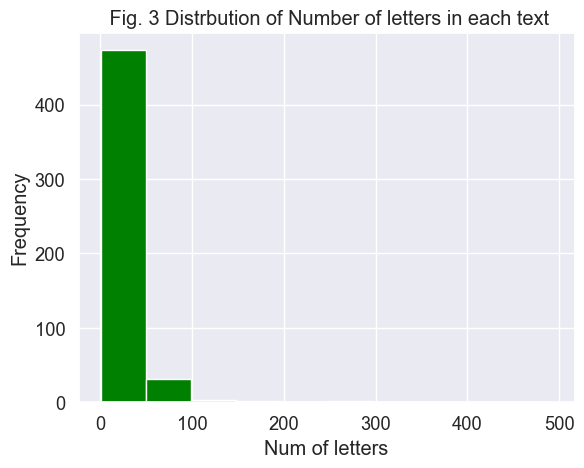

In [261]:
#lenght of letter in each word
letters_len=df['Pattern'].str.len()
#show histogram with letters lenght and color
plt.hist(letters_len,color='green')
#add title
plt.title(" Fig. 3 Distrbution of Number of letters in each text")
#add x and y label
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
#show image 
plt.show()

#amount of letters we will find in each text 

most our our patterns includes a lot  options, to increase our chances of mathing with user questions 

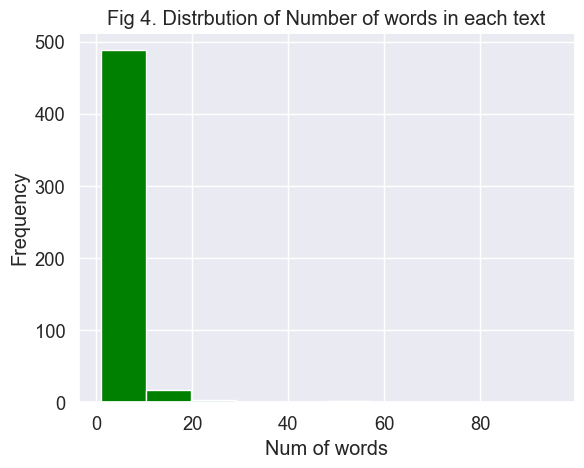

In [262]:
#get the lenght of each word in patterns 
words_len=df['Pattern'].str.split().map(lambda x: len(x))
#show histogram
plt.hist(words_len,color='green')
#add title
plt.title("Fig 4. Distrbution of Number of words in each text")
#add x , y label 
plt.xlabel("Num of words")
plt.ylabel("Frequency")
#show image 
plt.show()

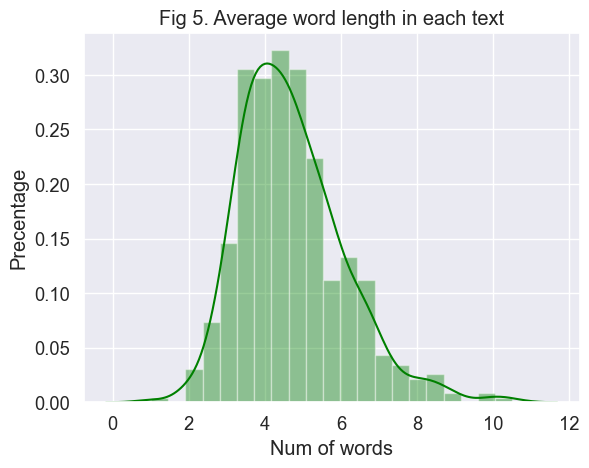

In [263]:
#show a distribution of the lenght of the word of each word 
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
#get the mean of each word 
word = word.map(lambda x: np.mean(x))
#show a distribution fig
sns.distplot(word,color='green')
#add title
plt.title("Fig 5. Average word length in each text")
#add x, y label 
plt.xlabel("Num of words")
plt.ylabel("Precentage")
#show image 
plt.show()

In [264]:
#get words frequency by creating an ngram
def getTopTextNGRAMS(corpus, n,g):
    #count vectorize corpus -> pattern
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    #get a bag of words 
    bag_of_words = vec.transform(corpus)
    #get a sum of all the words 
    sum_words = bag_of_words.sum(axis=0) 
    #iterate and get the word frequency 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #order words by frequency relevance 
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

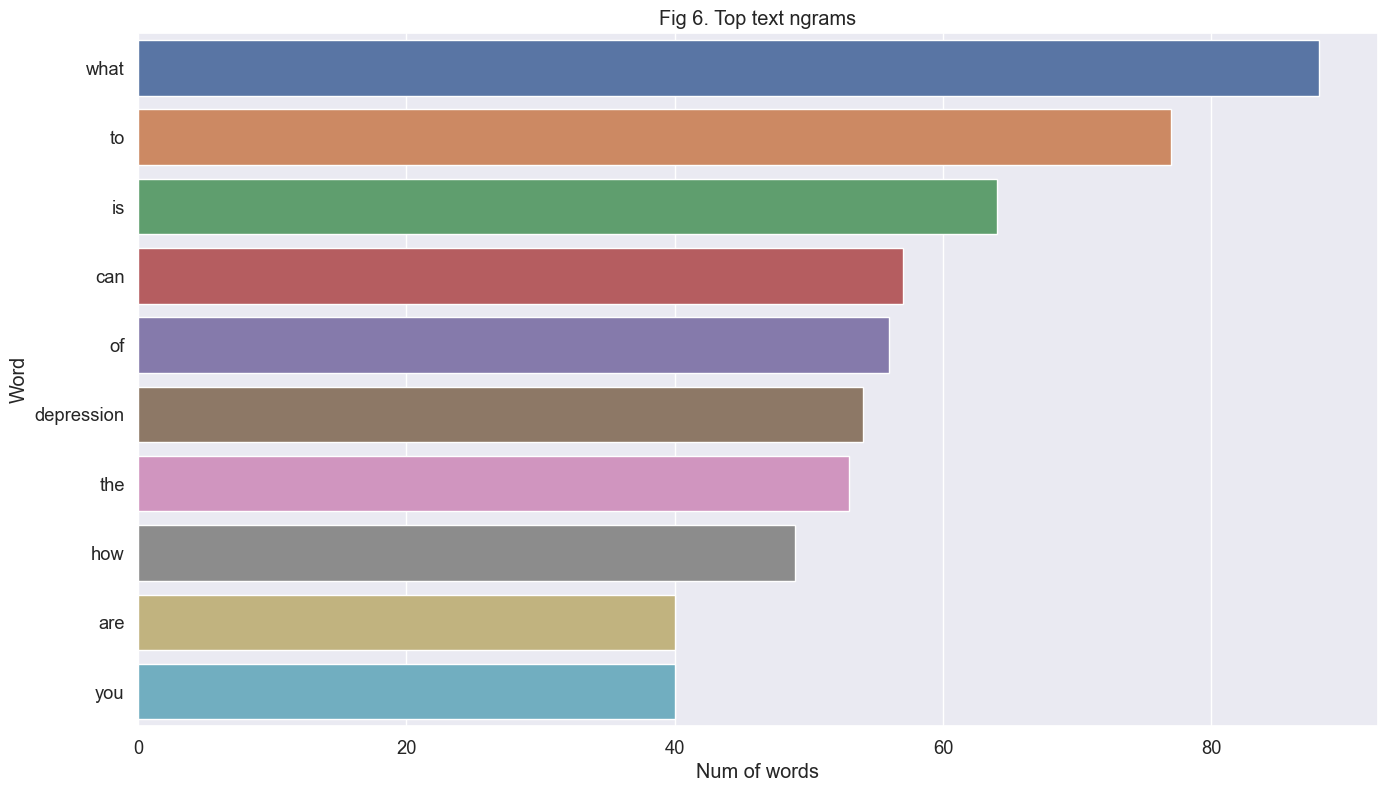

In [265]:
#figure size 
plt.figure(figsize = (16,9))
#get ngram
most_common_uni = getTopTextNGRAMS(df.Pattern,10,1)
#create a dict from ngram 
most_common_uni = dict(most_common_uni)
#create a barplot with the results 
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));
#show title
plt.title("Fig 6. Top text ngrams")
#show x,y labels 
plt.xlabel("Num of words")
plt.ylabel("Word")
plt.show()

In [266]:
#get list of words from dataframe
corpus = getCorpus(df.Pattern)
#show top five words 
corpus[:5]

['Hi', 'there', 'How', 'are', 'you']

In [267]:
#total words in our dataset 
print(f"dataset contains {len(corpus)} words")

dataset contains 2984 words


In [268]:
#most repeated words
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

#as we see most words are stop words that willbe handle shortly

{'I': 209,
 'What': 79,
 'to': 76,
 'a': 61,
 'of': 56,
 'the': 51,
 'is': 49,
 'How': 47,
 'about': 38,
 'for': 37}

#### 5. Data preprocessing

In [269]:
def processSentence(pattern):
     #lower case 
    pattern = pattern.lower()

    #remove contractions 
    pattern = expandContractions(pattern)

    #tokenize each word
    #w list of tokens
    w = nltk.word_tokenize(pattern)

    #correct any sentence spelling mistake
    w = correctSpelling(w)

    #remove stop words 
    w = removeStopWords(w)

    # lemmatize and add similar words
    w = generateVariations(w)

    return " ".join(w)  
    
       

In [270]:
#before preprocesing 
df.head(20)

,Pattern,Tag
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting
5,Hi,greeting
6,Hey,greeting
7,Hey there,greeting
8,Bye,goodbye
9,See you later,goodbye


In [271]:
#apply procesing using df.apply
df['Pattern'] = df['Pattern'].apply(processSentence)

In [272]:
#show results after preprocesing
df.head(20)



,Pattern,Tag
0,hi there,greeting
1,how be are you,greeting
2,be is anyone there,greeting
3,hello,greeting
4,good day,greeting
5,hi,greeting
6,hey,greeting
7,hey there,greeting
8,bye,goodbye
9,see you later,goodbye


In [273]:
#show original file 
mentalHealthDF.head()

,Pattern,Tag
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [274]:
df_processed = df.copy()
df_processed.head()

,Pattern,Tag
0,hi there,greeting
1,how be are you,greeting
2,be is anyone there,greeting
3,hello,greeting
4,good day,greeting


In [275]:
#get all the unique tags to feed our pretrained model 
labels = df_processed['Tag'].unique().tolist()
#remove any whitespace left or right 
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'thanks',
 'mental_health_depression',
 'mental_health_depression_resources',
 'what_is_depression',
 'let_parents_down',
 'types_of_depression',
 'good_for_nothing',
 'feeling_stressed',
 'suicidal_thoughts',
 'fear_of_failure',
 'causes_of_depression',
 'top_causes_of_depression',
 'highest_rate_of_depression_age_group',
 'highest_rate_of_depression_country',
 'lowest_rate_of_depression_country',
 'felling_depressed',
 'school_cause_of_depression',
 'biological_cause_of_depression',
 'global_impact_of_depression',
 'race_with_highest_rate_of_depression',
 'meaning_of_anxiety_and_depression',
 'oversleeping_and_depression',
 'lack_of_sleep_and_sadness',
 'depression_and_diabetes',
 'low_blood_sugar_suicidal',
 'how_long_anxiety_last',
 'stages_of_anxiety',
 'anxiety_age_peak',
 'why_is_anxiety_bad',
 '3_3_3_rule_anxiety',
 'control_thoughts',
 'thoughts_per_day',
 'reduce_anxiety',
 'loneliness',
 'no_one_likes_me',
 'i_am_ugly',
 'i_am_good_for_nothing',
 'i

In [276]:
#create our id to labels and labels to id, for the bert pre-trained model
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [277]:
#label lenghts 
len(label2id)


145

In [278]:
#add labels to df
df_processed['labels'] = df_processed['Tag'].map(lambda x: label2id[x.strip()])
df_processed.head()

,Pattern,Tag,labels
0,hi there,greeting,0
1,how be are you,greeting,0
2,be is anyone there,greeting,0
3,hello,greeting,0
4,good day,greeting,0


#### 6.Train / Test split

In [279]:
#get our X from pattern
X = list(df_processed['Pattern'])
X[:5]

['hi there', 'how be are you', 'be is anyone there', 'hello', 'good day']

In [280]:
#get y from labels
y = list(df_processed['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [281]:
#train split text with random_state =123
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

In [282]:
print(f'X_train dimenssions    {len(X_train)}')
print(f'X_test dimenssions    {len(X_test)}')
print(f'y_train dimenssions    {len(y_train)}')
print(f'y_test dimenssions    {len(y_test)}')

X_train dimenssions    385
X_test dimenssions    129
y_train dimenssions    385
y_test dimenssions    129


#### 7.Train the model

In [283]:
# Masked language modeling (MLM): taking a sentence, the model randomly masks 15% of the words in the input then run the entire masked sentence through the model and has to predict the masked words. This is different from traditional recurrent neural networks (RNNs) that usually see the words one after the other, or from autoregressive models like GPT which internally masks the future tokens. It allows the model to learn a bidirectional representation of the sentence.
# Next sentence prediction (NSP): the models concatenates two masked sentences as inputs during pretraining. Sometimes they correspond to sentences that were next to each other in the original text, sometimes not. The model then has to predict if the two sentences were following each other or not.

model_name = "bert-base-uncased"
max_len = 256

#create the tokenizer with a max lenght of 256, if any text in our pattern is bigger, it will be truncated
tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

#bert-large-uncased - it has 30k words variation
#leng of labels or tag we have, labels in format label to id and id to label 
model = BertForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [284]:
#tokenize X train and test 
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [285]:
#tokenize X
full_data = tokenizer(X, truncation=True, padding=True)

In [286]:
#get the data loader from pytorch for train and test 
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [287]:
#get data loader for the full_data
fullDataLoader = DataLoader(full_data, y_test)

In [288]:
#parameters for out model to train
training_args = TrainingArguments(
    output_dir='./output', 
    do_train=True,
    do_eval=True,
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=100,                
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)



In [289]:

#create a instance of the trainer, add model(bert with our labels ), training parameters, our data loaders,
#test dataset, and function with metrics to measure 
trainer = Trainer(
    model=model,
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=test_dataloader,            
    compute_metrics= computeMetrics
)

In [124]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,4.972300,4.894683,0.007752,0.001108,0.000585,0.010526
100,4.542600,4.524905,0.162791,0.051061,0.042450,0.094993
150,3.861600,4.004155,0.271318,0.142495,0.127453,0.191327
200,2.997800,3.501299,0.372093,0.240496,0.234843,0.271635
250,2.175900,3.189342,0.379845,0.246088,0.236776,0.280660
300,1.673600,2.920445,0.426357,0.307562,0.302056,0.337264
350,1.234000,2.730423,0.434109,0.315970,0.312941,0.337264
400,0.926300,2.578265,0.496124,0.370331,0.373428,0.397013
450,0.665900,2.444931,0.527132,0.401524,0.405452,0.418224
500,0.497200,2.311405,0.558140,0.431569,0.436950,0.453841


TrainOutput(global_step=1300, training_loss=0.9942382229291475, metrics={'train_runtime': 7626.0038, 'train_samples_per_second': 5.049, 'train_steps_per_second': 0.17, 'total_flos': 1624429873374000.0, 'train_loss': 0.9942382229291475, 'epoch': 100.0})

In [244]:
#evaluation result 
#add our evaluation results to dataset 
evaluationResults=[trainer.evaluate(eval_dataset=df_processed) for df_processed in [train_dataloader, test_dataloader]]

pd.DataFrame(evaluationResults, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,5.027303,0.01039,0.000232,0.000118,0.007143
test,5.014685,0.00000,0.000000,0.000000,0.000000


In [245]:
#test of precition 

#method that receives a text and base on the model(bert) will return a set of outputs, where we have included 
# the probability of each response to check how accurate is 
def predict(text):
    
     # Tokenize the input text and move to the appropriate device (MPS or CPU)
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to("mps")

    #send input to model 
    outputs = model(**inputs)

    #get probability of response
    probs = outputs[0].softmax(1)
    #get ID label predicted 
    pred_label_idx = probs.argmax()
     #get label predicted 
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [246]:
#simple test with a hello to see our results 
text = "Hello"
predict(text)


(tensor([[0.0103, 0.0063, 0.0059, 0.0055, 0.0100, 0.0062, 0.0095, 0.0062, 0.0038,
          0.0079, 0.0078, 0.0065, 0.0097, 0.0057, 0.0056, 0.0075, 0.0063, 0.0063,
          0.0062, 0.0057, 0.0051, 0.0063, 0.0058, 0.0085, 0.0049, 0.0049, 0.0054,
          0.0058, 0.0109, 0.0065, 0.0089, 0.0060, 0.0073, 0.0067, 0.0050, 0.0088,
          0.0064, 0.0055, 0.0066, 0.0087, 0.0087, 0.0062, 0.0082, 0.0097, 0.0114,
          0.0061, 0.0069, 0.0075, 0.0038, 0.0048, 0.0036, 0.0072, 0.0052, 0.0051,
          0.0040, 0.0066, 0.0060, 0.0065, 0.0101, 0.0074, 0.0077, 0.0106, 0.0073,
          0.0047, 0.0119, 0.0062, 0.0130, 0.0113, 0.0098, 0.0042, 0.0057, 0.0073,
          0.0104, 0.0075, 0.0086, 0.0042, 0.0083, 0.0062, 0.0074, 0.0060, 0.0093,
          0.0074, 0.0055, 0.0055, 0.0056, 0.0080, 0.0039, 0.0086, 0.0069, 0.0097,
          0.0066, 0.0057, 0.0041, 0.0041, 0.0100, 0.0096, 0.0065, 0.0092, 0.0064,
          0.0048, 0.0081, 0.0135, 0.0057, 0.0087, 0.0047, 0.0052, 0.0048, 0.0088,
          0.0101

In [183]:
#indicate the path to save our model 
model_path = "chatbot"
#save model and pretrained model 
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [184]:
#path to retreive trained files 
model_path = "chatbot"

#get model 
model = BertForSequenceClassification.from_pretrained(model_path)
#get tokes 
tokenizer= BertTokenizerFast.from_pretrained(model_path)

#send pretrained and saved model and tokenization, device =cpu, since is mac and we dont have gpu 
chatbot= pipeline(task="text-classification", model=model, tokenizer=tokenizer, function_to_apply="softmax")



In [185]:
chatbot.model.save_pretrained(model_path)

In [186]:
chatbot("Hello")

[{'label': 'highest_rate_of_depression_age_group',
  'score': 0.015294828452169895}]

In [187]:

#create a simple program to test the chatbot 
def chat(chatbot):
    
    print("Alice: Hello, I'm Alice you Mental Health assistance, how can I help you?")
    print("Type 'quit' to exit the chat\n\n")
    
    #get user input
    userInput = input("User: ").strip().lower()
    
    #while user requires to stay in the chat 
    while(userInput != 'quit'):

        #send user input to chatbot (pipeline with our model and tokens)
        #get score 
        score = chatbot(userInput)[0]['score']
        
        #if score is less than 80% we do not return an aswer
        if score < 0.8:
            print("Alice: Sorry, I can not understand you, try with different prompt..\n\n")
            #ask for user input
            userInput = input("User: ").strip().lower()
            continue
        
        #get our lavel response 
        label = label2id[chatbot(userInput)[0]['label']]
        #get response 
        response = random.choice(intents['intents'][label]['responses'])
        
        #show our score, label and response 
        print(f"Alice: score {score}, label: {label}, response:  {response}\n\n")
        
        
        #get user input 
        userInput = input("User: ").strip().lower()
        
        

In [136]:
#run chat
chat(chatbot)

Alice: Hello, I'm Alice you Mental Health assistance, how can I help you?
Type 'quit' to exit the chat


User:Is anyone there?
Alice: score 0.9872174859046936, label: 0, response:  Hi there, how can I help?


User:I need help with mental health'
Alice: score 0.9065111875534058, label: 4, response:  I'm sorry you're feeling this way. It's important to talk to someone you trust.


User:I need help with mental health
Alice: score 0.9303769469261169, label: 4, response:  I'm sorry you're feeling this way. It's important to talk to someone you trust.


User:What are the types of depression?
Alice: Sorry, I can not understand you, try with different prompt..


User:What are the types of depression
Alice: Sorry, I can not understand you, try with different prompt..


User:I'm worthless.
Alice: score 0.9358236193656921, label: 8, response:  There are many different forms of depression but the most common types are:


User:Am I suffering from depression?
Alice: score 0.8761599659919739, label: 